# Generate plot showing the efect of moment delta mapping on the quantifle function at individual location and day of year.
- PI= Pre-industrial, EOC= End-of-21st-century
- MDM - moment delta mapping
- QDM - Quantile delta mapping

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
import numbers
#np.set_printoptions(threshold=np.inf)
from scipy.special import erfinv, erf
import xskillscore as xs
from datetime import datetime, timedelta

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.23.0,>=1.16.5'), {'scipy'}))'.
  numba.core.entrypoints.init_all()
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.2

In [2]:
def gauss_quantile(mean,std,quantile):
    #quantile must be a real number neteoceen 0 and 1
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue
    

In [3]:
#SGP
LAT        = 36.605
LON        = (360-97.485)%360
# #Bengaluru:
# LAT2        = 12.9716
# LON2        = 77.5946
#Berkeley
# LAT       = 37.8715
# LON       = (360-122.2730)%360
savefigs   = '/global/scratch/users/harsha/savefigs/Feb21/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
cvals_det  = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
loc1      = 'SGP'
# loc2       = 'Bengaluru/'
# locn2      = 'Bengaluru'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
print(LAT,LON)

36.605 262.515


In [4]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [5]:
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_shift(ds_obs,init_mean,final_mean):
    # Assuming coordinates year and day for ds_obs
    obs_mean   = ds_obs.mean('year')
    ds_shift   = obs_mean + (final_mean - init_mean) + ds_obs - obs_mean        
    return ds_shift

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

In [6]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=2, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(1)

In [7]:
cluster

Dashboard: http://10.0.39.8:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.39.8:34223,Workers: 0
Dashboard: http://10.0.39.8:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
pi_year  = 1865
eoc_year = 2085
doy      =  211# day_of_year #211 = Jul 30
# date     = 'Jul30'

In [9]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')
###############################
date = no_leap_date(doy)
date

'July 30'

In [10]:
%%time
pi_det   = xr.open_zarr(cvals_det+'pi_detrended.zarr').detrended_tmax
eoc_det  = xr.open_zarr(cvals_det+'eoc_detrended.zarr').detrended_tmax
#
pi_det

CPU times: user 655 ms, sys: 370 ms, total: 1.02 s
Wall time: 1.15 s


<xarray.DataArray 'detrended_tmax' (lat: 192, lon: 288, member: 100, year: 30,
                                    dayofyear: 365)>
dask.array<open_dataset-5fb251677075321de8a48b5d992e505edetrended_tmax, shape=(192, 288, 100, 30, 365), dtype=float64, chunksize=(8, 60, 100, 10, 73), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 220 221 222 223 224 225 ... 142 143 144 145 146
    degree     int64 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879

In [11]:
pi_sgp   = pi_det.sel(lat=LAT,lon=LON,method='nearest').sel(dayofyear=doy).sel(year=slice(pi_year0,pi_year1))
eoc_sgp  = eoc_det.sel(lat=LAT,lon=LON,method='nearest').sel(dayofyear=doy).sel(year=slice(ic_year0,ic_year1))      
pi_sgp

<xarray.DataArray 'detrended_tmax' (member: 100, year: 30)>
dask.array<getitem, shape=(100, 30), dtype=float64, chunksize=(100, 10), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  int64 211
    degree     int64 ...
    lat        float64 36.28
    lon        float64 262.5
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879

In [12]:
pi_sgp_mean  = pi_sgp.mean('year')
eoc_sgp_mean = eoc_sgp.mean('year')
pi_sgp_std   = pi_sgp.std('year')
eoc_sgp_std  = eoc_sgp.std('year')

### Implement MDM and QDM

In [13]:
sgp_mdm = implement_mdm(pi_sgp,pi_sgp_mean,eoc_sgp_mean,pi_sgp_std,eoc_sgp_std)
sgp_mdm

<xarray.DataArray 'detrended_tmax' (member: 100, year: 30)>
dask.array<add, shape=(100, 30), dtype=float64, chunksize=(100, 10), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  int64 211
    degree     int64 1
    lat        float64 36.28
    lon        float64 262.5
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879

In [14]:
qsgp_mdm = compute_quantiles(sgp_mdm)
qsgp_eoc = compute_quantiles(eoc_sgp)
qsgp_pi  = compute_quantiles(pi_sgp)

In [15]:
# Compute QDM
qsgp_qdm = implement_qdm(qsgp_pi, qsgp_pi, qsgp_eoc)

CPU times: user 14.8 s, sys: 820 ms, total: 15.6 s
Wall time: 52.5 s


Text(0.5, 1.03, 'July 30 at SGP')

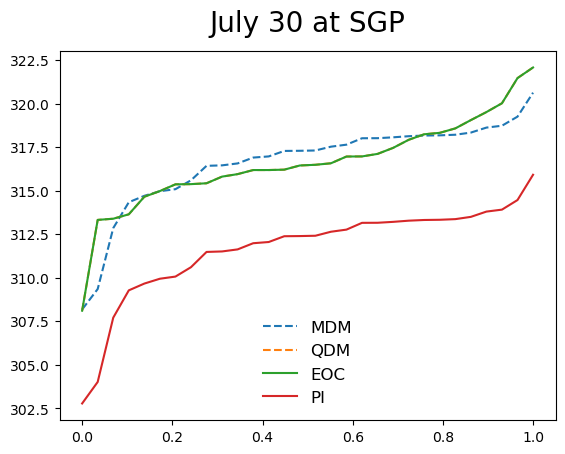

In [16]:
%%time
member = 0
plt.plot(quants,qsgp_mdm.sel(member=member),'--',label='MDM')
plt.plot(quants,qsgp_qdm.sel(member=member),'--',label='QDM')
plt.plot(quants,qsgp_eoc.sel(member=member),label='EOC')
plt.plot(quants,qsgp_pi.sel(member=member),label='PI')
plt.legend(loc='lower center',prop={'size': 12},frameon=False)
plt.title('July 30 at '+loc1,fontweight=200,fontsize=20, y=1.03)

#### Compute Ensemble Mean (emean)

In [17]:
qsgp_mdm_emean = qsgp_mdm.mean('member')
qsgp_eoc_emean = qsgp_eoc.mean('member')
qsgp_pi_emean  = qsgp_pi.mean('member')
qsgp_pi_emean 

<xarray.DataArray 'detrended_tmax' (quantile: 30)>
dask.array<mean_agg-aggregate, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

In [18]:
print(cvals_det+loc1+'_mdm_quantiles_'+date+'_'+ic_year0+'_'+ic_year1+'.zarr')

/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/SGP_mdm_quantiles_July 30_2071_2100.zarr


In [19]:
# %%time
# qsgp_mdm_emean.to_dataset().to_zarr(cvals_det+loc1+'_mdm_quantiles_'+date+'_'+ic_year0+'_'+ic_year1+'.zarr')

In [20]:
plt.plot(quants,qsgp_mdm_emean,color='blue',label=r'$\bar{L_2(Q_h^m)}$',lw=2)
plt.plot(quants,qsgp_eoc_emean,'k--',label=r'$\bar{Q_f^m$}',lw=2)
plt.plot(quants,qsgp_pi_emean,'-.',color='k',label= r'$\bar{Q_h^m}$',lw=2)
plt.legend(loc='lower center',prop={'size': 14},frameon=False)
plt.title('July 30 at '+loc1,fontweight=200,fontsize=20, y=1.03)
plt.ylabel('Quantile function (K)',fontweight=200,fontsize=15,labelpad=15)
plt.xlabel('Probability p',fontweight=200,fontsize=15,labelpad=15)

Text(0.5, 0, 'Probability p')

ValueError: 
\bar{Q_f^m
          ^
Expected {accentprefixed | accent | symbol | c_over_c | function | group | frac | dfrac | binom | genfrac | overset | underset | sqrt | overline | operatorname}, found end of text  (at char 10), (line:1, col:11)

<Figure size 640x480 with 1 Axes>

In [ ]:
#################################################################

In [19]:
print(tpi_loc1_det.mean().values,tpi_loc1_det.std().values)
print(tdpi_loc1.mean().values,tdpi_loc1.std().values)

312.07744041320103 2.9335378394886846
312.07437 2.9340196


In [20]:
%%time
print(teoc_loc1_det.mean().values,teoc_loc1_det.std().values)
print(tdeoc_loc1.mean().values,tdeoc_loc1.std().values)

315.67468008100366 3.3098502099169993
315.69565 3.3296711
CPU times: user 3min 6s, sys: 8.11 s, total: 3min 14s
Wall time: 5min 14s


### Plots for different locations

CPU times: user 785 ms, sys: 67.3 ms, total: 853 ms
Wall time: 1.07 s


(290.0, 330.0)

Matplotlib is building the font cache; this may take a moment.


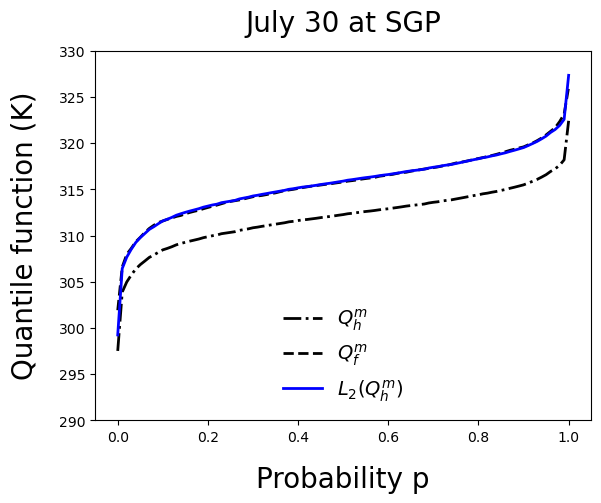

In [30]:
%%time
#Plotting for loc1
plt.plot(quants,qmsc_loc1_det,color='blue',label=r'$L_2(Q_h^m)$',lw=2)
plt.plot(quants,qeoc_loc1_det,'k--',label=r'$Q_f^m$',lw=2)
plt.plot(quants,qpi_loc1_det,'-.',color='k',label= r'$Q_h^m$',lw=2)
plt.legend(loc='lower center',prop={'size': 14},frameon=False)
plt.title('July 30 at '+locn1,fontweight=200,fontsize=20, y=1.03)
plt.ylabel('Quantile function (K)',fontweight=200,fontsize=20,labelpad=15)
plt.xlabel('Probability p',fontweight=200,fontsize=20,labelpad=15)
plt.ylim(290,330)